## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
# df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [ ]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Terdapat missing values pada column 'Age', 'Cabin', dan 'Embarked'.

In [ ]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Missing Values

In [ ]:
# Cek persentase missing value
def count_null(df):
    null_column = df.isnull().sum()
    percentage = null_column / len(df)
    missing_data = pd.concat([null_column, percentage], axis=1, keys=['Total Null', 'Percentage'])
    print(missing_data[missing_data['Total Null'] > 0])

In [ ]:
count_null(df_train)

          Total Null  Percentage
Age              177    0.198653
Cabin            687    0.771044
Embarked           2    0.002245


#### Solving 'Age' missing values

In [ ]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_train['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_test['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

#### Solving "Embarked" missing values

In [ ]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')

#### Solving "Cabin" missing values

In [ ]:
# Dropping the Cabin feature
df_train.drop(['Cabin'], inplace=True, axis=1)
df_test.drop(['Cabin'], inplace=True, axis=1)

#### Solving "Fare" missing values

In [ ]:
med_fare = df_test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

In [ ]:
df_train.isnull().sum()
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Correlations

In [ ]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [ ]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.5
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.5495


In [ ]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.5
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.57749


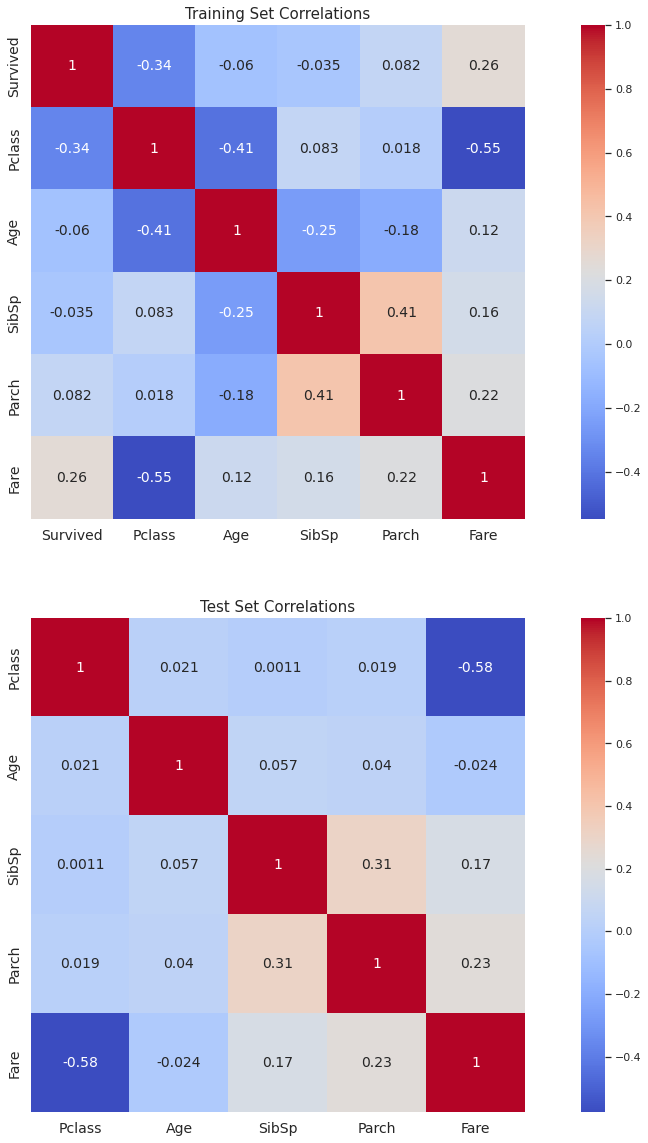

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## Feature Engineering Preprocess

### Data Binning

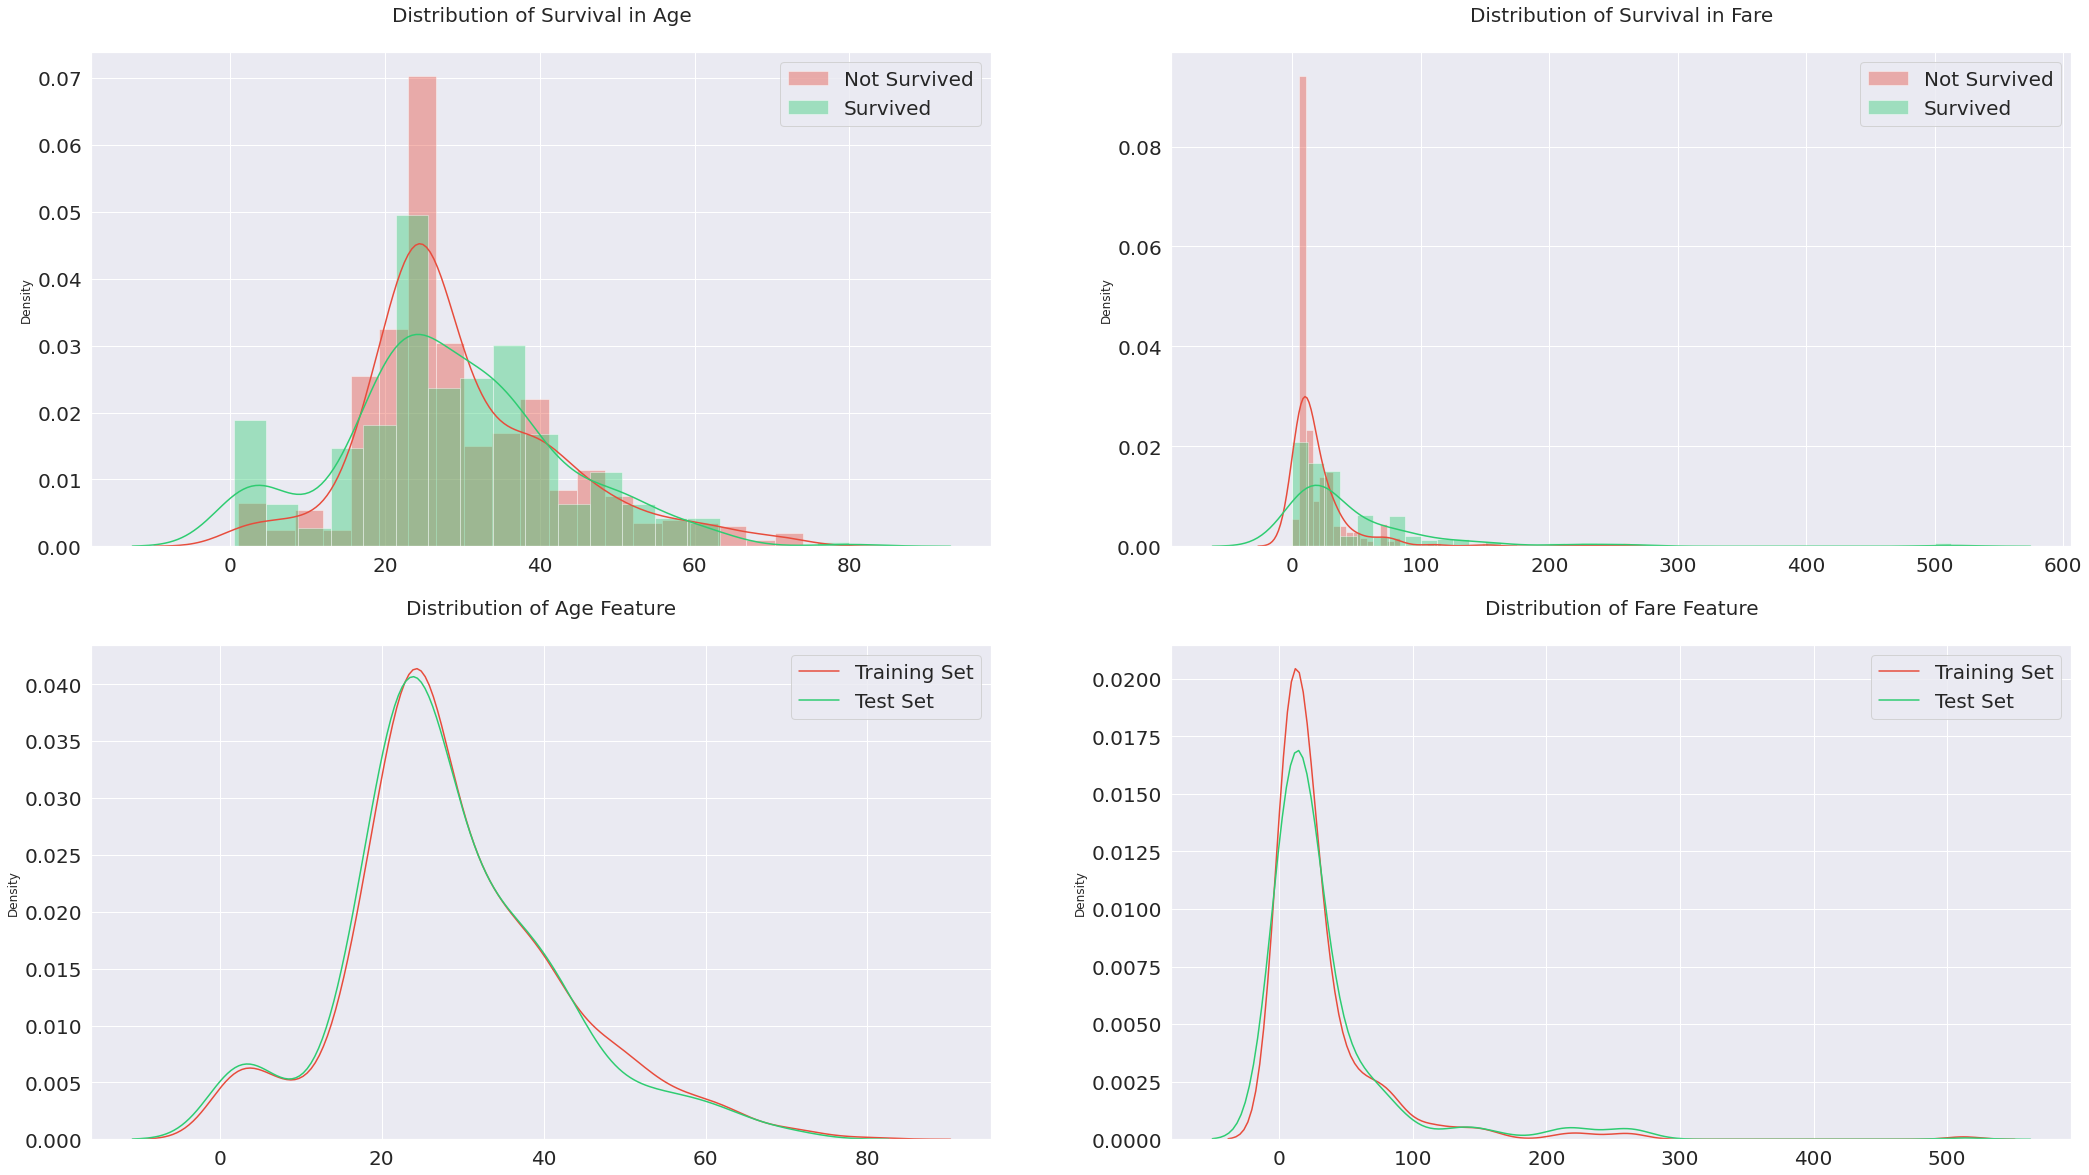

In [ ]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [ ]:
df_train['Fare'] = pd.qcut(df_train['Fare'], 13)
df_test['Fare'] = pd.qcut(df_test['Fare'], 13)

In [ ]:
df_train['Age'] = pd.qcut(df_train['Age'], 10)
df_test['Age'] = pd.qcut(df_test['Age'], 10)

### Encoding

In [ ]:
dfs = [df_train, df_test]
non_numeric_features = ['Embarked', 'Sex', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [ ]:
dfs[1].isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [ ]:
cat_features = ['Pclass', 'Sex', 'Embarked']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:3]], axis=1)
df_test = pd.concat([df_test, *encoded_features[3:]], axis=1)

In [ ]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_1', 'Sex_2', 'Embarked_1', 'Embarked_2', 'Embarked_3'],
      dtype='object')

In [ ]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Sex_1          0
Sex_2          0
Embarked_1     0
Embarked_2     0
Embarked_3     0
dtype: int64

## Feature Selection

### Filtering with Correlation Threshold

Akan digunakan metode filter dengan melihat correlation antar fitur. Threshold dari correlation adalah 0.5, sehingga jika terdapat dua fitur dengan correlation < 0.5, salah satu fitur akan di-drop.

Setelah dilakukan correlation analysis dari data train dan data test pada bagian Exploratory Data Analysis, didapat Fare dan Pclass memiliki correlation di atas threshold, sehingga atribut Fare akan di-drop.

Selain itu, fitur Name dan Ticket juga akan didrop karena model yang digunakan hanya dapat menerima input numerik.

In [ ]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,7,1,0,PC 17599,11,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,3,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,7,1,0,113803,10,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,7,0,0,373450,3,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,5,0,0,211536,5,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",0,1,0,0,112053,9,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,2,1,2,W./C. 6607,7,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",1,4,0,0,111369,9,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
df_train_fs = df_train.drop(['Fare'], axis=1)
df_train_fs

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,7,1,0,PC 17599,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,7,1,0,113803,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,7,0,0,373450,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,5,0,0,211536,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",0,1,0,0,112053,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,2,1,2,W./C. 6607,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",1,4,0,0,111369,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
df_test_fs = df_test.drop(['Fare'], axis=1)
df_test_fs

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,892,3,"Kelly, Mr. James",1,3,0,0,330911,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,7,1,0,363272,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,894,2,"Myles, Mr. Thomas Francis",1,5,0,0,240276,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,895,3,"Wirz, Mr. Albert",1,7,0,0,315154,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,7,1,1,3101298,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,6,0,0,A.5. 3236,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,8,0,0,PC 17758,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
415,1307,3,"Saether, Mr. Simon Sivertsen",1,2,0,0,SOTON/O.Q. 3101262,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
416,1308,3,"Ware, Mr. Frederick",1,7,0,0,359309,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
df_train_fs.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Embarked', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_1', 'Sex_2', 'Embarked_1', 'Embarked_2', 'Embarked_3'],
      dtype='object')

In [ ]:
X_train_fs = df_train_fs.drop(['Survived', 'Name', 'Ticket'], axis=1).values
y_train_fs = df_train_fs['Survived'].values
X_test_fs = df_test_fs.drop(['Name', 'Ticket'], axis=1).values

## Feature Extraction

Untuk feature extraction, digunakan LDA karena task merupakan klasifikasi.

### LDA

In [ ]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Sex_1          0
Sex_2          0
Embarked_1     0
Embarked_2     0
Embarked_3     0
dtype: int64

In [ ]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Sex_1          0
Sex_2          0
Embarked_1     0
Embarked_2     0
Embarked_3     0
dtype: int64

In [ ]:
drop_cols = ['Embarked', 'Survived', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']
drop_cols_test = ['Embarked', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']

X_train_lda = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train_lda = df_train_fs['Survived'].values
X_test_lda = StandardScaler().fit_transform(df_test.drop(columns=drop_cols_test))

print('X_train_lda shape: {}'.format(X_train_lda.shape))
print('y_train_lda shape: {}'.format(y_train_lda.shape))
print('X_test_lda shape: {}'.format(X_test_lda.shape))

X_train_lda shape: (891, 10)
y_train_lda shape: (891,)
X_test_lda shape: (418, 10)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_lda, y_train_lda)
X_test_lda = lda.transform(X_test_lda)

In [ ]:
X_train_lda

array([[-1.18765898],
       [ 2.37390097],
       [ 0.74843982],
       [ 2.03269341],
       [-1.56322938],
       [-1.02830037],
       [-0.20559747],
       [-1.06693877],
       [ 0.6663827 ],
       [ 2.25161163],
       [ 1.02459548],
       [ 1.89461558],
       [-1.12295947],
       [-1.5892658 ],
       [ 1.04629249],
       [ 1.25433861],
       [-0.82986244],
       [-0.53500356],
       [ 0.58432557],
       [ 1.25376163],
       [-0.6947784 ],
       [-0.60838188],
       [ 1.28770823],
       [ 0.0879158 ],
       [ 1.02459548],
       [ 0.50226845],
       [-0.91115093],
       [ 0.37275026],
       [ 1.145291  ],
       [-1.2653767 ],
       [ 0.29104553],
       [ 2.36956157],
       [ 1.1496304 ],
       [-0.82417742],
       [ 0.42912336],
       [-0.13221915],
       [-0.91115093],
       [-1.19633779],
       [ 0.95121716],
       [ 1.37882125],
       [ 0.52396546],
       [ 1.54785188],
       [-0.91982974],
       [ 2.24727222],
       [ 1.21866931],
       [-1

## Model

In [ ]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

In [ ]:
def fold(X_train, y_train, X_test):
  N = 5
  oob = 0
  probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
  fprs, tprs, scores = [], [], []

  skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

  for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
      print('Fold {}\n'.format(fold))
      
      # Fitting the model
      single_best_model.fit(X_train[trn_idx], y_train[trn_idx])
      
      # Computing Train AUC score
      trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], single_best_model.predict_proba(X_train[trn_idx])[:, 1])
      trn_auc_score = auc(trn_fpr, trn_tpr)
      # Computing Validation AUC score
      val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], single_best_model.predict_proba(X_train[val_idx])[:, 1])
      val_auc_score = auc(val_fpr, val_tpr)  
        
      scores.append((trn_auc_score, val_auc_score))
      fprs.append(val_fpr)
      tprs.append(val_tpr)

      
      # X_test probabilities
      probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = single_best_model.predict_proba(X_test)[:, 0]
      probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = single_best_model.predict_proba(X_test)[:, 1]
          
      oob += single_best_model.oob_score_ / N
      print('Fold {} OOB Score: {}\n'.format(fold, single_best_model.oob_score_))   
      
  print('Average OOB Score: {}'.format(oob))
  return fprs, tprs

In [ ]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

### Feature Selection

In [ ]:
fprs_fs, tprs_fs = fold(X_train_fs, y_train_fs, X_test_fs)

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 1 OOB Score: 0.8075842696629213

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s


Fold 2 OOB Score: 0.7994389901823282

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 3 OOB Score: 0.8218793828892006

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 4 OOB Score: 0.8078541374474053

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s


Fold 5 OOB Score: 0.7952314165497896

Average OOB Score: 0.806397639346329


[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished


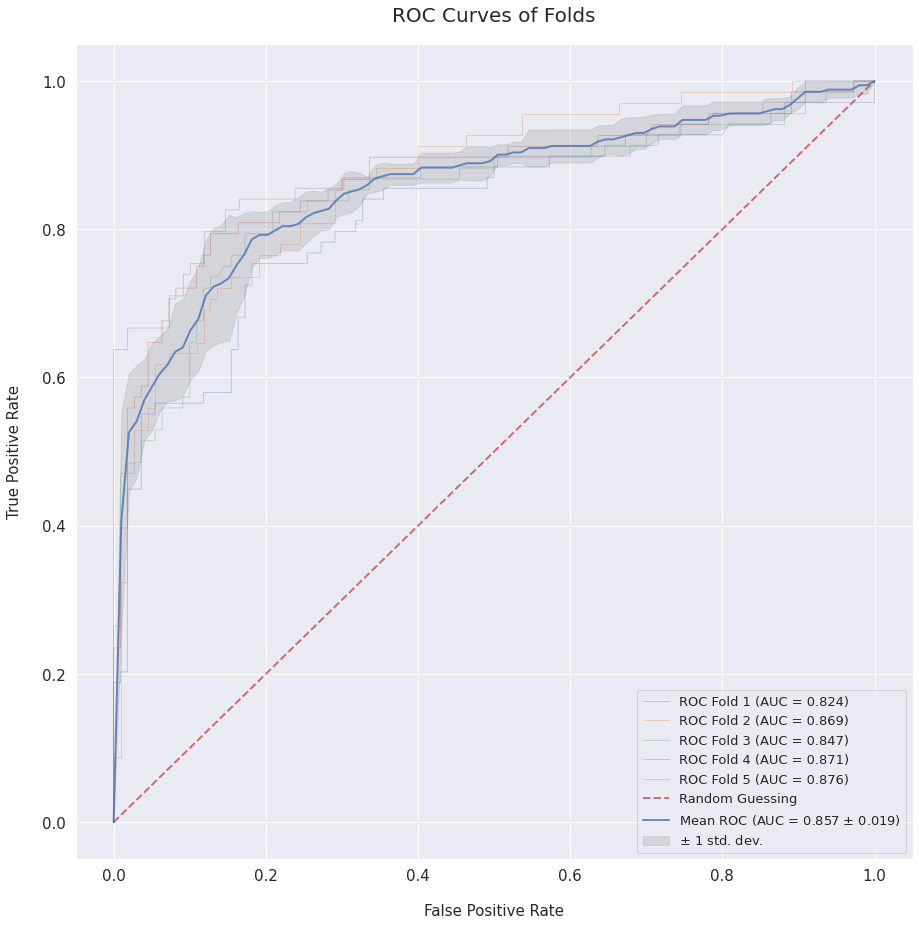

In [ ]:
plot_roc_curve(fprs_fs, tprs_fs)

### Feature Extraction

In [ ]:
fprs_lda, tprs_lda = fold(X_train_lda, y_train_lda, X_test_lda)

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 1 OOB Score: 0.8117977528089888

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 2 OOB Score: 0.7980364656381487

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s


Fold 3 OOB Score: 0.8106591865357644

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Fold 4 OOB Score: 0.814866760168303

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s


Fold 5 OOB Score: 0.8064516129032258

Average OOB Score: 0.8083623556108861


[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished


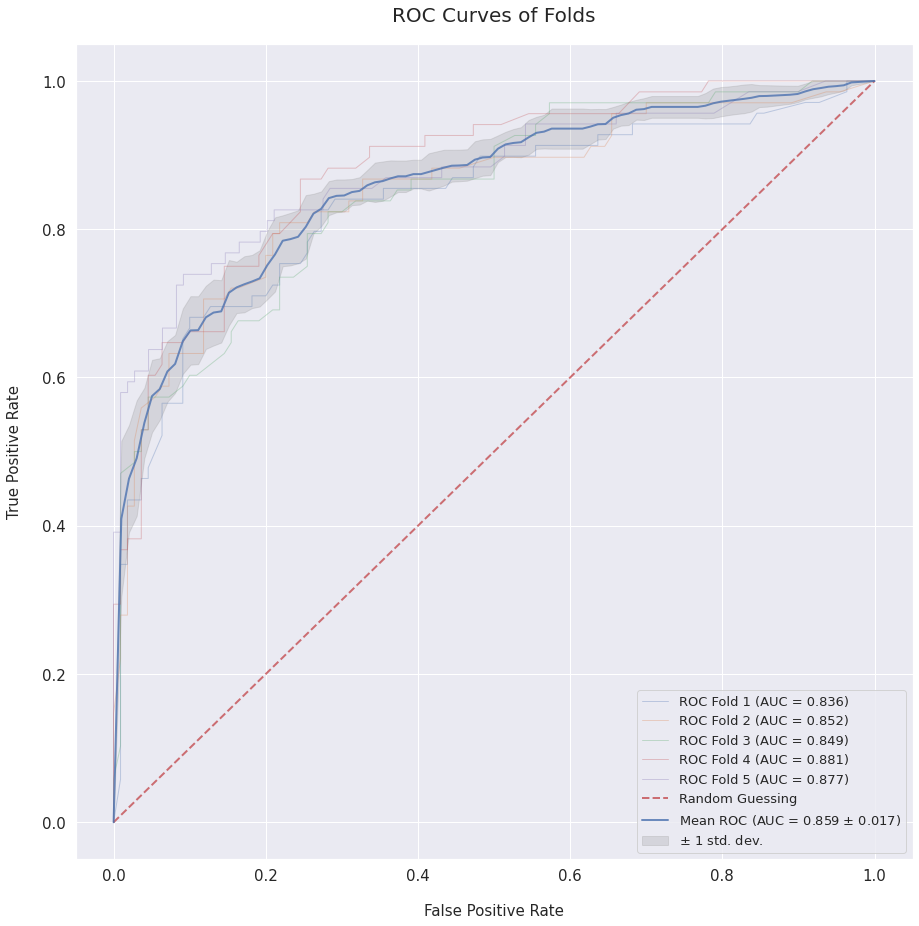

In [ ]:
plot_roc_curve(fprs_lda, tprs_lda)